In [1]:
# Import
import os
from dataloader import BatchDataloader
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import pgd_attack, train_loop, eval_loop, train_loop_apgd
import utils
import ecg_plot
from models import ResNet1d, ResNet1dGELU
import ast
%matplotlib inline

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

Use device: cuda



In [3]:
batch_size = 32
div = 1 # divide the training data by this amount

In [6]:
# Load the data
dataset_path = '../code-15'

path_to_csv = dataset_path + '/exams.csv'
path_to_val = dataset_path + '/10.h5'
path_to_train = dataset_path + '/90.h5'

# Get labels
df = pd.read_csv(path_to_csv, index_col='exam_id')

# Print how many there are of the following age groups 2-15 16-25, 26-40, 41-60, 61-80, 81-100
print(df[(df['age'] >= 2) & (df['age'] <= 15)].shape[0])
print(df[(df['age'] >= 18) & (df['age'] <= 25)].shape[0])
print(df[(df['age'] >= 26) & (df['age'] <= 40)].shape[0])
print(df[(df['age'] >= 41) & (df['age'] <= 60)].shape[0])
print(df[(df['age'] >= 61) & (df['age'] <= 80)].shape[0])
print(df[(df['age'] >= 81) & (df['age'] <= 100)].shape[0])

print(df.shape[0])

# Get h5 file
train_file = h5py.File(path_to_train, 'r')
train_traces_ids = train_file['exam_id']

val_file = h5py.File(path_to_val, 'r')
val_traces_ids = val_file['exam_id']

# Only keep the traces in the csv that match the traces in the h5 file
train_df = df[df.index.isin(train_traces_ids)]
val_df = df[df.index.isin(val_traces_ids)]

# Define traces
train_traces = train_file['tracings']
val_traces = val_file['tracings']

# Sort the dataframe in trace order
train_df = train_df.reindex(train_traces_ids)
val_df = val_df.reindex(val_traces_ids)

# Get labels
train_labels = train_df['age'].values
val_labels = val_df['age'].values

# Only use x% of the training data
train_traces = train_traces#[:len(train_traces)//div]
train_labels = train_labels#[:len(train_labels)//div]

# Count each label
unique, counts = np.unique(val_labels, return_counts=True)

# Print it
print(dict(zip(unique, counts)))

unique_train, counts_train = np.unique(train_labels, return_counts=True)
print(dict(zip(unique_train, counts_train)))

# Print size of training and validation set
print(f"Training set size: {len(train_labels)}")
print(f"Validation set size: {len(val_labels)}")

# Make into torch tensor
train_labels = torch.tensor(train_labels, dtype=torch.float32).reshape(-1,1)
val_labels = torch.tensor(val_labels, dtype=torch.float32).reshape(-1,1)

# Define dataloaders
train_dataloader = BatchDataloader(train_traces, train_labels, batch_size=batch_size)
val_dataloader = BatchDataloader(val_traces, val_labels, batch_size=batch_size)

0
33096
67129
100783
112636
28155
345779
{17: 383, 18: 355, 19: 394, 20: 425, 21: 399, 22: 430, 23: 427, 24: 426, 25: 451, 26: 396, 27: 412, 28: 438, 29: 458, 30: 413, 31: 429, 32: 447, 33: 429, 34: 481, 35: 469, 36: 462, 37: 455, 38: 484, 39: 422, 40: 464, 41: 488, 42: 481, 43: 482, 44: 505, 45: 532, 46: 494, 47: 504, 48: 476, 49: 495, 50: 514, 51: 520, 52: 472, 53: 550, 54: 541, 55: 536, 56: 502, 57: 508, 58: 511, 59: 506, 60: 484, 61: 510, 62: 535, 63: 504, 64: 487, 65: 550, 66: 580, 67: 509, 68: 571, 69: 567, 70: 608, 71: 600, 72: 561, 73: 561, 74: 588, 75: 540, 76: 567, 77: 574, 78: 564, 79: 601, 80: 561, 81: 618, 82: 612, 83: 564, 84: 559, 85: 510, 86: 72, 87: 33, 88: 15, 89: 7, 91: 1, 100: 4}
{17: 3597, 18: 3616, 19: 3673, 20: 3691, 21: 3723, 22: 3764, 23: 3756, 24: 3761, 25: 3805, 26: 3882, 27: 3867, 28: 3948, 29: 3948, 30: 4023, 31: 3945, 32: 3984, 33: 4010, 34: 3980, 35: 4088, 36: 4115, 37: 4109, 38: 4115, 39: 4264, 40: 4192, 41: 4270, 42: 4272, 43: 4334, 44: 4348, 45: 4347, 

In [5]:
# hyperparameters
learning_rate = 1e-4
weight_decay = 1e-2
num_epochs = 10#*div
adversarial_delay = num_epochs # Do not perform adversarial training until epoch x
start_eps = 1e-3
end_eps = 1e-2

# for exponential schedule
eps_values = np.exp(np.linspace(np.log(start_eps), np.log(end_eps), num_epochs - adversarial_delay))

In [14]:
pretrained_model_path_suffix = "../models/age/ptb_20_apgd_5e-2"
pretrained_model_path_file = "/latest.pth"
pretrained_model_path = pretrained_model_path_suffix + pretrained_model_path_file
output_model_path = pretrained_model_path_suffix + "_code15_lr1e-4_div" + str(div)
os.makedirs(output_model_path, exist_ok=True)

is_finetuning = True

In [15]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

tqdm.write("Define model...")
model = ResNet1dGELU(input_dim=(12, 4096), n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8

if is_finetuning:
    tqdm.write("Loading pretrained model...")
    checkpoint = torch.load(pretrained_model_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    
model.to(device=device)
tqdm.write("Done!\n")

loss_function = nn.MSELoss()
#loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all, adv_valid_loss_all = [], [], []
mse_all, mae_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    adversarial = False if epoch <= adversarial_delay else True
    adv_eps = 0 if epoch <= adversarial_delay else eps_values[epoch - adversarial_delay - 1]

    train_loss = train_loop_apgd(epoch, train_dataloader, model, optimizer, loss_function, device, adversarial=adversarial, adv_eps=adv_eps, adv_iters=10, adv_restarts=1)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, val_dataloader, model, loss_function, device)
    # # adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(epoch, val_dataloader, model, loss_function, device, adversarial=True)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)
    # adv_valid_loss_all.append(adv_valid_loss)

    # compute validation metrics for performance evaluation
    mse = mean_squared_error(y_true, y_pred)
    mse_all.append(mse)

    mae = mean_absolute_error(y_true, y_pred)
    mae_all.append(mae)

    # # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, output_model_path + '/best.pth') 
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    torch.save({'model': model.state_dict()}, output_model_path + '/latest.pth') 

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                #'Adversarial Loss {adv_valid_loss:.6f} \t'
                'MSE {mse:.6f} \t'
               'MAE {mae:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        #adv_valid_loss=adv_valid_loss,
                        mse=mse,
                        mae=mae,
                        model_save=model_save_state))

Define model...
Loading pretrained model...
Done!

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 8.273864 	Valid Loss 6.924229 	MSE 221.292297 	MAE 11.762984 	Best model -> saved


Training Epoch  2:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 6.679740 	Valid Loss 6.430755 	MSE 205.487747 	MAE 11.224573 	Best model -> saved


Training Epoch  3:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 6.264659 	Valid Loss 6.271296 	MSE 200.391098 	MAE 11.029612 	Best model -> saved


Training Epoch  4:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 6.050541 	Valid Loss 6.052963 	MSE 193.401855 	MAE 10.754818 	Best model -> saved


Training Epoch  5:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 5.829494 	Valid Loss 5.788848 	MSE 184.975815 	MAE 10.486395 	Best model -> saved


Training Epoch  6:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 5.669584 	Valid Loss 5.551048 	MSE 177.374100 	MAE 10.235771 	Best model -> saved


Training Epoch  7:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 5.558398 	Valid Loss 5.546850 	MSE 177.246475 	MAE 10.234554 	Best model -> saved


Training Epoch  8:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 5.443800 	Valid Loss 5.394604 	MSE 172.403168 	MAE 10.071180 	Best model -> saved


Training Epoch  9:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 5.365453 	Valid Loss 5.384965 	MSE 172.087463 	MAE 10.044570 	Best model -> saved


Training Epoch 10:   0%|          | 0/1081 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/1078 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 5.244122 	Valid Loss 5.314993 	MSE 169.878754 	MAE 9.984125 	Best model -> saved


In [16]:
# Save the metrics to file together with the hyperparameters
metrics = {'train_loss': train_loss_all,
           'valid_loss': valid_loss_all,
           'mse': mse_all,
           'mae': mae_all,
           'hyperparameters':
               {'learning_rate': learning_rate,
                'weight_decay': weight_decay,
                'num_epochs': num_epochs,
                'batch_size': batch_size,
                'adversarial_delay': adversarial_delay,
                'adv_eps': adv_eps,
                'adv_alpha': adv_eps/5,
                'adv_steps': 10}}

torch.save(metrics, output_model_path + '/metrics.pth')

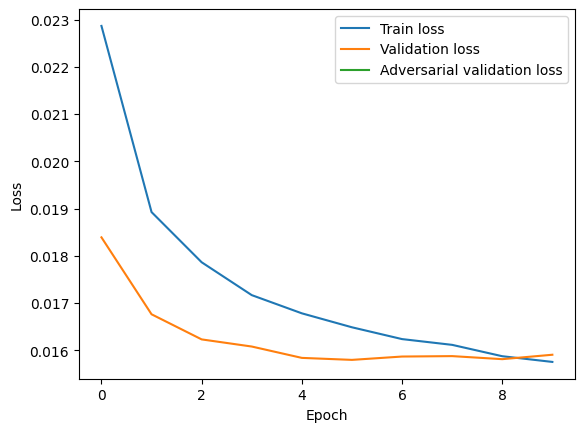

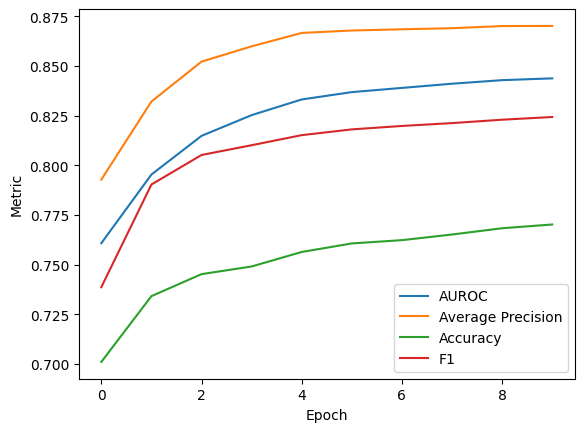

Max AP: 0.8702115009378065


In [10]:
# Load the metrics
metrics = torch.load(output_model_path + '/metrics.pth')
# Plot the training and validation loss
plt.figure()
plt.plot(metrics['train_loss'], label='Train loss')
plt.plot(metrics['valid_loss'], label='Validation loss')
plt.plot(metrics['adv_valid_loss'], label='Adversarial validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the AUROC, AP, accuracy and F1
plt.figure()
plt.plot(metrics['auroc'], label='AUROC')
plt.plot(metrics['ap'], label='Average Precision')
plt.plot(metrics['accuracy'], label='Accuracy')
plt.plot(metrics['f1'], label='F1')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

# Print max AP 
max_ap = max(metrics['ap'])
print(f"Max AP: {max_ap}")

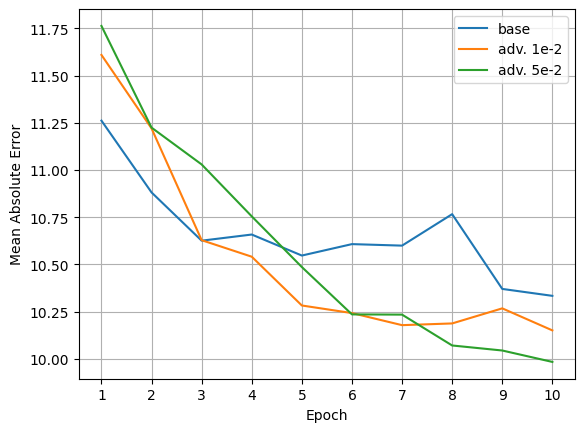

In [20]:
# Load the metrics for each model
models = ['../models/age/ptb_20_code15_lr1e-4_div1', '../models/age/ptb_20_apgd_1e-2_code15_lr1e-4_div1', '../models/age/ptb_20_apgd_5e-2_code15_lr1e-4_div1']
epochs_range = range(1, num_epochs+1)

plt.figure()
for model in models:
    loaded_metrics = torch.load(model + '/metrics.pth')
    auroc = loaded_metrics['mae']
    plt.plot(epochs_range, auroc)

plt.xticks(epochs_range)
#plt.yticks(np.arange(0.7, 0.9, 0.05))
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.legend(["base", "adv. 1e-2", "adv. 5e-2"])
plt.show()

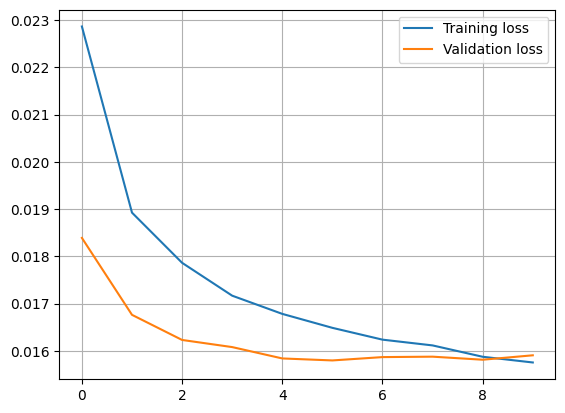

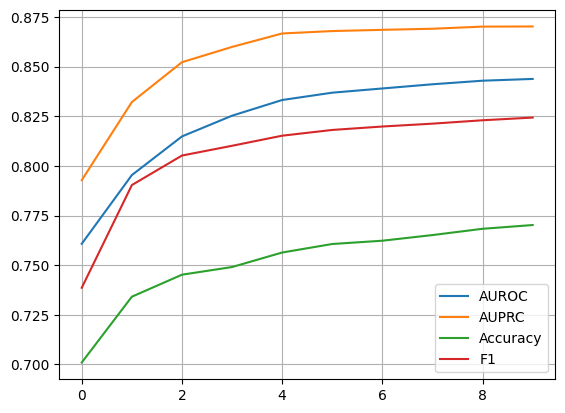

In [12]:
# plot training and validation loss
plt.figure()
plt.plot(train_loss_all, label='Training loss')
plt.plot(valid_loss_all, label='Validation loss')
plt.legend()
plt.grid()
plt.show()

# plot validation metrics
plt.figure()
plt.plot(auroc_all, label='AUROC')
plt.plot(ap_all, label='AUPRC')
plt.plot(accuracy_all, label='Accuracy')
plt.plot(f1_all, label='F1')
plt.legend()
plt.grid()
plt.show()